<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Summary-of-Analysis" data-toc-modified-id="Summary-of-Analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Summary of Analysis</a></span><ul class="toc-item"><li><span><a href="#Intent" data-toc-modified-id="Intent-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Intent</a></span></li><li><span><a href="#Approach" data-toc-modified-id="Approach-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Approach</a></span></li><li><span><a href="#Further-Research" data-toc-modified-id="Further-Research-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Further Research</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Load-Clean-Character-Data" data-toc-modified-id="Load-Clean-Character-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Clean Character Data</a></span></li></ul></li><li><span><a href="#Fit-Conditional-DCGAN-(2-Characters)" data-toc-modified-id="Fit-Conditional-DCGAN-(2-Characters)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit Conditional DCGAN (2 Characters)</a></span><ul class="toc-item"><li><span><a href="#Explore-Variety-on-the-images-in-the-batch" data-toc-modified-id="Explore-Variety-on-the-images-in-the-batch-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Explore Variety on the images in the batch</a></span></li><li><span><a href="#Check-the-Quality-of-the-Discriminator-(Solo)" data-toc-modified-id="Check-the-Quality-of-the-Discriminator-(Solo)-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Check the Quality of the Discriminator (Solo)</a></span></li><li><span><a href="#Check-the-Quality-of-the-Generator-(Solo)" data-toc-modified-id="Check-the-Quality-of-the-Generator-(Solo)-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Check the Quality of the Generator (Solo)</a></span></li></ul></li><li><span><a href="#Fit-Optimized-Conditional-GAN---'a'-&amp;-'j'" data-toc-modified-id="Fit-Optimized-Conditional-GAN---'a'-&amp;-'j'-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fit Optimized Conditional GAN - 'a' &amp; 'j'</a></span></li><li><span><a href="#Fit-Conditional-DCGAN-(62-Characters)" data-toc-modified-id="Fit-Conditional-DCGAN-(62-Characters)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Fit Conditional DCGAN (62 Characters)</a></span><ul class="toc-item"><li><span><a href="#Load-Clean-Character-Data" data-toc-modified-id="Load-Clean-Character-Data-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load Clean Character Data</a></span></li><li><span><a href="#Defining-Functions-for-62-Charachters" data-toc-modified-id="Defining-Functions-for-62-Charachters-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Defining Functions for 62 Charachters</a></span></li></ul></li></ul></div>

## Summary of Analysis

### Intent

In this notebook I explore multiple Generative Adversarial Nextwork (GAN) archiectures—including a Deep Convolutional GAN and a Conditional GAN—in order to generate new and realistic typeface characters. The goal of this notebook is to generate a new, cohesive typeface consisting of 62 characters.

### Approach

- With 2 characters ('a' and 'j') cleaned and free from unreadable characters from the EDA phase, I began by training a baseline Deep Convolutional GAN using the architecture in the book 'Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems' as a staring point. The modifications I made include best practices for image generation, including: sigmoid activation in the discriminator, tanh activation in the generator, and the use of a leaky relu between each convolutional layer. 


- Utilizing a GPU on Google colab, I trained the network on the 'a' characters for 100 epochs, and the 'j' characters for 300 epochs. The 300 epoch fit cycle produced visually better results with no signs of mode collapse.  


- With a succesful baseline GAN trained, the next step was to advance the architecture to a conditional GAN, one capable of producing the character of a specified class. While the ultimate intent is to fit a conditional GAN on all 62 classes, the conditional architecture was tested on the 2 classes ('a' and 'j') generating pairs of characters as a proof of concept before introducing all classes and generating cohesive typefaces. For the sake of fit time, this model was fit on Google colab for 50 epochs.  


- After 50 epochs, the results of the conditional GAN are good. The characters are clear and the character pairs appear to belong together. Bolder 'a's are generated next to bolder 'j's etc, though there appears to be a lack of variety when compared to latent spaces of these characters explored during EDA.


- To optimize the DCGAN architecture for additional variance in the generated images, I adjusted the constraints on the generated latent points that feed the generator. It was observed that the original DCGAN was generating points in a very narrow band of the latent space for each character. By adding a random multiple (between -25 & 25) to the generated points, the optimized model was able to generate 'a' and 'j' characters that show much more diversity in shape, thickness, slant and overall style.

### Further Research

- I will extend this approach to the remaining 60 characters in the dataset to generate a cohesive typeface. I will also standardize the scale of each character's latent space (-1 - 1) to simplify the training.

- With account approval from AWS, I will run the final model as close to 50 epochs as possible on the full set of characters. As an plan B, I will condense the dataset to strictly lowercase characters (26) to save on compute from the full 62.


- With additional time, I'll take the image processing a bit further to smooth out the image of each character, and then transfer the generated images into outside software to create a usable, new-to-the-world typeface.

## Modeling

### Load Clean Character Data

In [1]:
from PIL import Image, ImageDraw, ImageFont
import os, sys, shutil
from pathlib import Path
import glob
from imageio import imread
from skimage.transform import resize
import cv2

import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import tensorflow
from tensorflow.python.keras.layers import Input, Reshape, Dense, Flatten, Conv2D, Conv2DTranspose, Embedding, Concatenate
from tensorflow.python.keras.models import Model, Sequential, load_model
from tensorflow.python.keras.layers.core import Dense, Dropout
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import initializers

In [2]:
tensorflow.config.run_functions_eagerly(True)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [104]:
#inspect the class order for 'a' and 'j' set
folder='classes_aj/'
class_folders = os.listdir(folder)
class_folders.remove('.DS_Store')
class_folders

['a', 'j']

In [42]:
#Use Datagenerator to load in the clean character data
#Keeping these at full size (224x224px) with a batch size of 64
datagen = ImageDataGenerator(rescale=1/255)
char_gen = datagen.flow_from_directory(folder, target_size=(224, 224), batch_size=64, color_mode='grayscale', shuffle=True, class_mode='categorical', classes=class_folders)

Found 7254 images belonging to 2 classes.


In [62]:
X, y = next(char_gen)

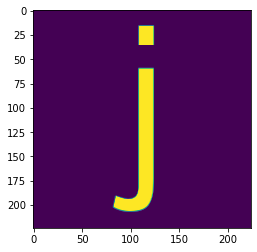

In [105]:
#Quick inspect of the data
first_char = X[0]
plt.imshow(first_char)
plt.show()

In [13]:
#Verify the classes line up
idx = list(y[0]).index(1)
print(class_folders[idx])

j


In [84]:
print(X.shape)
print(y.shape)

(64, 224, 224, 1)
(64, 2)


## Fit Conditional DCGAN (2 Characters)

The conditional GAN using the distinct function approach as outlined in the 'Hands-On Machine Learning...' book.  
Structuring each component of the GAN into their own function before compiling and trainging the model.

In [85]:
def define_conditional_discriminator(in_shape=(224, 224, 1), n_classes=2):
    #Create label embedding
    #Use 76 as the embedding output dimensions (worked better than 50)
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 76)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    #Concatenate with class label
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    #Downsample to reduce size
    fe = Conv2D(128, kernel_size=(3, 3), strides=(2,2))(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    #Downsample again
    fe = Conv2D(128, kernel_size=(3, 3), strides=(2,2))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    #Flatten for output layer
    fe = Flatten()(fe)
    fe = Dropout(0.25)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model([in_image, in_label], out_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [86]:
def define_conditional_generator(latent_dim, n_classes=2):
    #Prepare and size input
    #Starting with smaller (56x56px) images
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 76)(in_label)
    n_nodes = 56*56
    li = Dense(n_nodes)(li)
    li = Reshape((56, 56, 1))(li)
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 56 * 56
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((56, 56, 128))(gen)
    
    #Concatenate with class label
    merge = Concatenate()([gen, li])
    #Upsample to 112x112
    gen = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2))(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    #Upsample again to 224x224
    gen = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2))(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Conv2D(1, kernel_size=(4, 4), activation='tanh')(gen)
    model = Model([in_lat, in_label], out_layer)
    return model

In [87]:
def define_conditional_gan(g_model, d_model):
    #Prevent descriminator from being trained by default
    #Will specifically control this in the training loop
    d_model.trainable = False
    gen_noise, gen_label = g_model.input
    gen_output = g_model.output
    gan_output = d_model([gen_output, gen_label])
    model = Model([gen_noise, gen_label], gan_output)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [88]:
def generate_conditional_real_samples(X, y, n_samples):
    #Pull random data from X and y
    idx = np.random.randint(0, X.shape[0], n_samples)
    X, labels = X[idx], y[idx]
    #Set labels as 'real' for descriminator
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [168]:
#Helper function to generate fake samples
def generate_conditional_latent_points(latent_dim, n_samples, n_classes=2):
    #Generate random data
    scale_int = random.randint(-25, 25) #new line to scale the latent points
    x_input = scale_int * np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    #Set labels as 'fake' for descriminator
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [90]:
def generate_conditional_fake_samples(generator, latent_dim, n_samples):
    z_input, labels_input = generate_conditional_latent_points(latent_dim, n_samples)
    images = generator.predict([z_input, labels_input])
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [91]:
#Training loop
def train_conditional(g_model, d_model, gan_model, char_gen, latent_dim, filename, n_epochs=100, n_batch=64):
    batch_per_epoch = int(7254 / n_batch) #Number of images
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        batches = 0
        #Loop through DataImageGenerator fully for each epoch
        for X, y in char_gen:
            y = np.array([np.array(list(cls).index(1)) for cls in y])
            #Toggle trainability of descriminator
            d_model.trainable = True
            [X_real, labels_real], y_real = generate_conditional_real_samples(X, y, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels_fake], y_fake = generate_conditional_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_conditional_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            d_model.trainable = False
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, batches+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
            batches += 1
            if batches >= batch_per_epoch:
              #Break manually to avoid infinite loop
              break
    g_model.save('{}.h5'.format(filename))

In [92]:
#Helper function to show plot of generated images
def show_conditional_plot(examples, n):
    # plot images
    figure(figsize=(20,20))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

In [173]:
#Define models for 'a' and 'j' chars
latent_dim = 2 #from 100
discriminator = define_conditional_discriminator()
generator = define_conditional_generator(latent_dim)
gan_model = define_conditional_gan(generator, discriminator)

In [ ]:
#Trained on Google Colab to utilize GPU
train_conditional(generator, discriminator, gan_model, char_gen, latent_dim, 'conditional_test50', n_epochs=50)

**Train Screenshot from Google Colab**
<img src="images/GAN_train_aj_2.png">

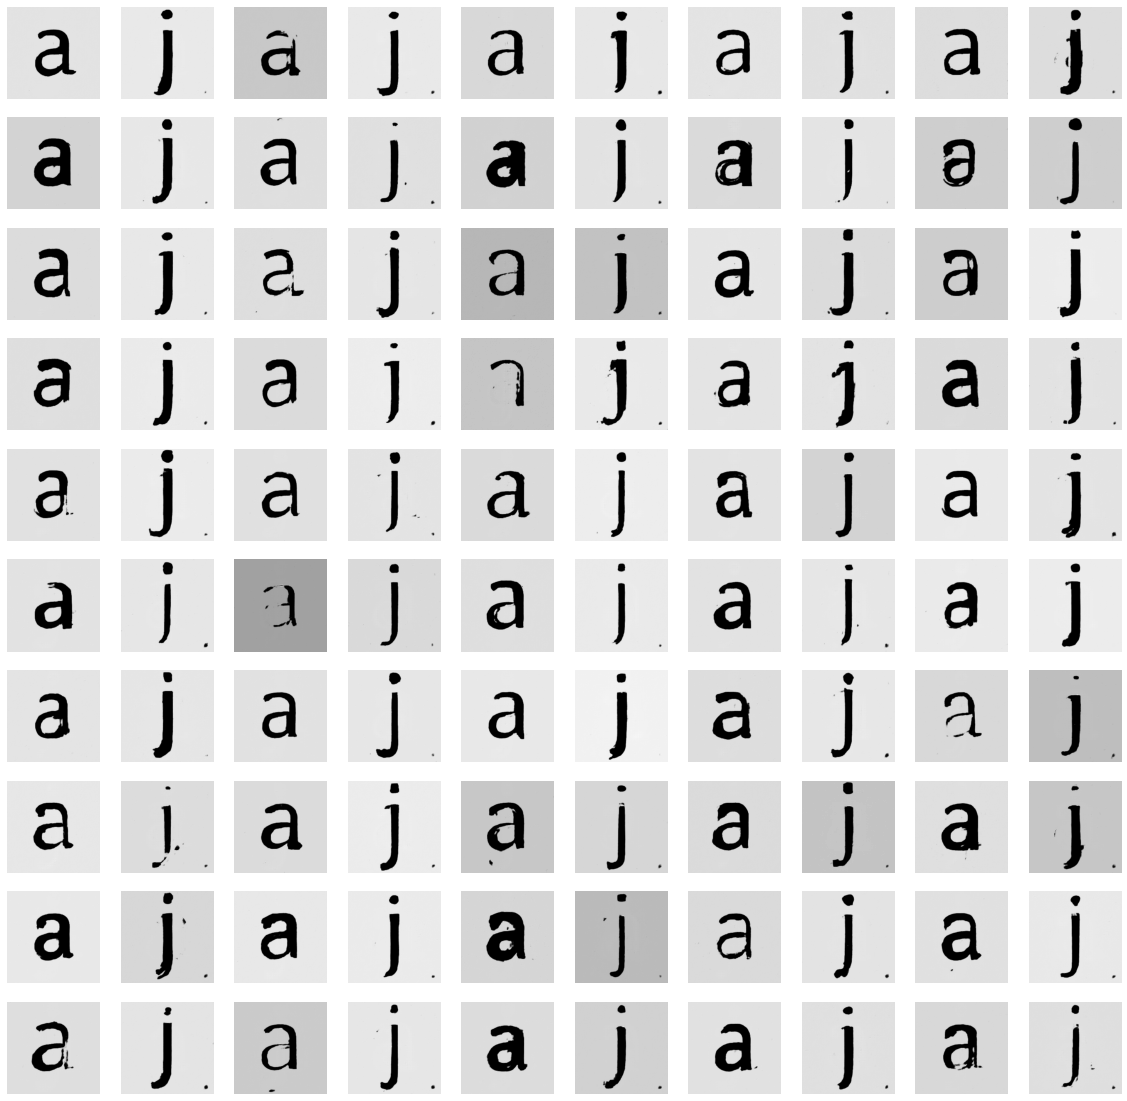

In [155]:
#Load model
model = load_model('conditional_test50.h5')

#Generate points for 100 images
latent_points, labels = generate_conditional_latent_points(100, 100)

#Specify labels, 50 'a' and 'j' pairs
labels = np.asarray([x for _ in range(50) for x in range(2)])

#Generate images using generated points
Xc  = model.predict([latent_points, labels])

#Show generated images in 10x10 grid
show_conditional_plot(Xc, 10)

It appears that the 'a' and 'j' pairs roughly belong together.  
I can observe bolder 'a's paired with bolder 'j's etc, which is a good sign the latent spaces are similar for these characters.  
The generated images do lack variety, however.  
All of the characters follow the same structure and do not represent the full breadth of the latent space as seen in the EDA phase.

**Next Steps:**
I will expand this baseline DCGAN to the full set of characters, then I will attempt to improve the variance in the generated images by adjusting the architecture of the model and training the discriminator further. 

### Explore Variety on the images in the batch

In [58]:
#Import helper function to display full batch (from EDA notebook)
import ipynb.fs
from .defs.Type_Image_Collection_EDA_v3 import show_image_batch_grid

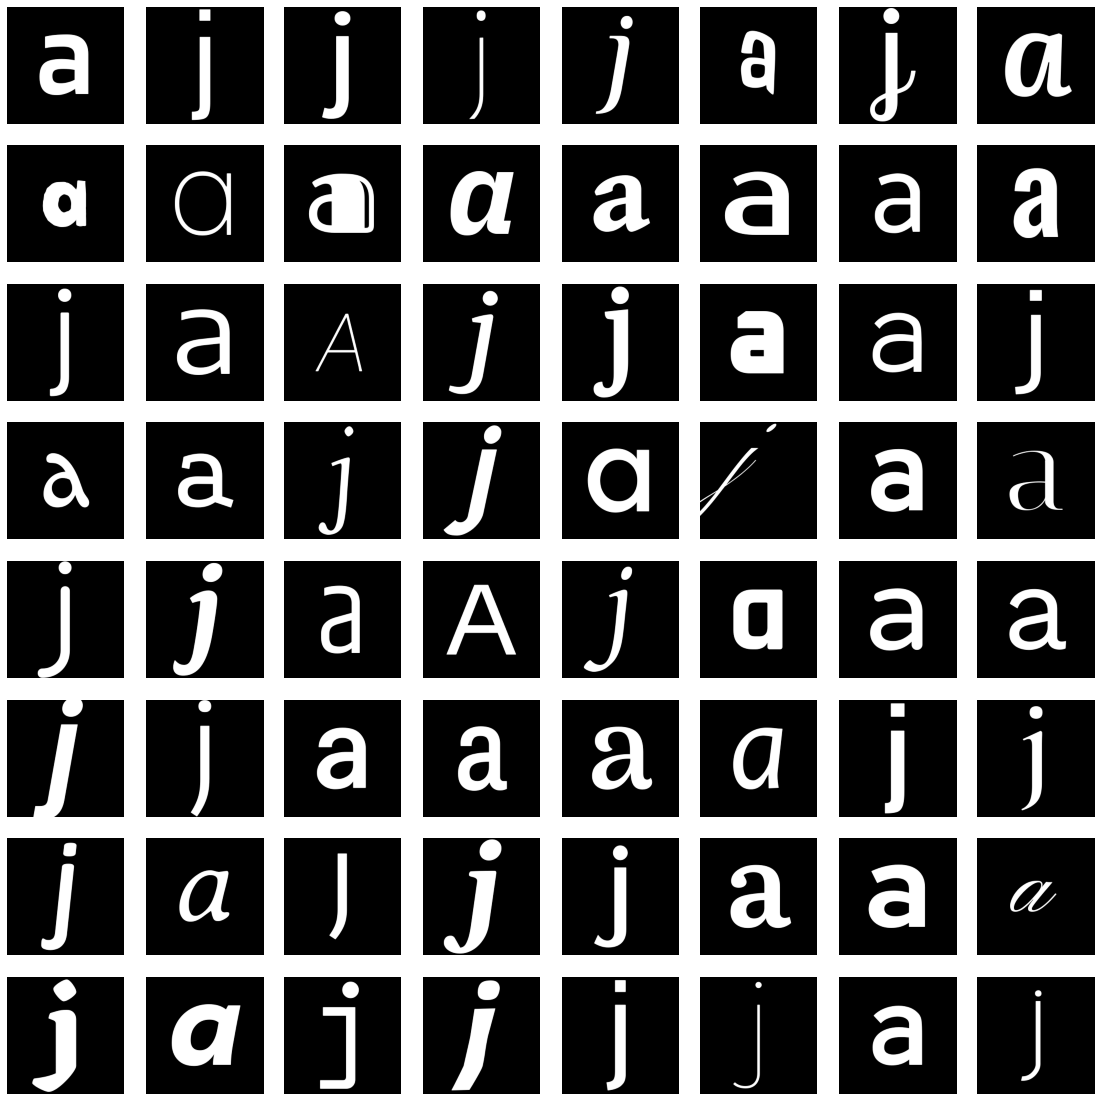

In [63]:
show_image_batch_grid(X, 8, 8, label_list=None, show_labels=False, figsize=(20,20))

**Finding:** There's definitely a lot more variety in the batch than the output suggests.

### Check the Quality of the Discriminator (Solo)

In [97]:
y_list = np.array([np.array(list(cls).index(1)) for cls in y])
[X_real, labels_real], y_real = generate_conditional_real_samples(X, y_list, 64)
discriminator.trainable = True
aj_discrim_loss, _ = discriminator.train_on_batch([X_real, labels_real], y_real)

In [98]:
aj_discrim_loss

0.6807047128677368

In [100]:
X, y = next(char_gen)
y_list = np.array([np.array(list(cls).index(1)) for cls in y])

In [103]:
discriminator.evaluate(x=[X, y_list], y=y_list)

2/2 [==============================] - 2s 828ms/step - loss: 2.3334 - accuracy: 0.3906


[2.3334012031555176, 0.390625]

The discriminator appears to working as expected. Research suggested the loss float under and around 0.7 and the data going into it looks both diverse and accurate.

### Check the Quality of the Generator (Solo)

In [158]:
print(generate_conditional_latent_points(2, 32))

[array([[-0.93470426,  0.06006781],
       [ 0.56960385,  0.5230613 ],
       [ 0.3983441 , -0.54398505],
       [-0.05471032,  0.80236217],
       [-0.16637385, -0.04159879],
       [ 0.22750201, -0.41227643],
       [-0.24067502,  0.31778754],
       [-1.33996894,  1.66017646],
       [ 0.37110554, -0.05820212],
       [ 0.04882591,  0.75214514],
       [ 0.91965571, -0.59643565],
       [-2.30496044, -1.94805479],
       [ 0.05438242,  1.83155459],
       [-0.8781529 , -0.21156653],
       [-0.61230305,  0.87359093],
       [ 1.15575697,  0.73104509],
       [-0.55858157,  0.1555502 ],
       [-2.06762209,  0.17765271],
       [ 2.34093007,  0.46094084],
       [-0.627488  ,  1.22840661],
       [ 0.55914585,  0.58594963],
       [ 2.26498024, -0.24482579],
       [-1.58994923,  0.15539678],
       [ 1.54420665, -0.19171757],
       [-0.61904075, -1.10880334],
       [ 1.70751569, -2.09573987],
       [-0.85725314, -0.77251818],
       [-0.44986916, -0.2185937 ],
       [ 0.38376503

**Obeservation:** Now this looks like something.  
The latent dimensions created by the generator look to be off by about a factor of 25.  
The latent space explored in the EDA phase ranged between -75 and 75. While the above ranges between about -3 and 3. 
Below is what the dimensions look like with that function updated.

**Solution:** I will the latent point generation function and refit the generator (and DCGAN) and explore the results.

In [219]:
#UPDATED Helper function to generate fake samples
def generate_conditional_latent_points_scaled(latent_dim, n_samples, n_classes=2):
    #Generate random data
    scale_int = random.randint(-25, 25) #new line to scale the latent points
    x_input = scale_int * np.random.randn(latent_dim * n_samples)
    z_input = x_input.reshape(n_samples, latent_dim)
    #Set labels as 'fake' for descriminator
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [176]:
print(generate_conditional_latent_points_scaled(2, 32))

[array([[  8.23493495,  -7.79154965],
       [ 15.99649803,  -2.60819179],
       [ 13.34579676,  -0.36718686],
       [ 13.0349264 ,   5.65579148],
       [-17.39623738, -26.51575446],
       [  8.86394923,   6.91466279],
       [ 28.80833919,  -5.54346921],
       [  7.04964427,  10.38462446],
       [  1.84591264,  -9.72311347],
       [ 14.04915737,  10.09135061],
       [ -5.62437436,   2.34875741],
       [  0.51574347,  -9.70656597],
       [ 14.94696076, -28.57577834],
       [ 12.59081713, -10.34301444],
       [ 20.11368578,  -3.92536977],
       [ 23.70959084,  17.35439809],
       [ 10.30588016,  22.83653027],
       [  4.02535255, -13.40502282],
       [ 11.25245866,   1.85889388],
       [ 20.66080519,  14.24800528],
       [  0.57181738,   8.23951031],
       [ -9.45000562,  -9.01091452],
       [  0.64251111,   0.22116257],
       [  4.45929308,  -5.46816905],
       [-15.34728181,   7.45308949],
       [-10.30802133,   8.19558444],
       [-18.99719021,  23.11775415],


## Fit Optimized Conditional GAN - 'a' & 'j'

In [220]:
#Define models for 'a' and 'j' chars
latent_dim = 2
discriminator = define_conditional_discriminator()
generator = define_conditional_generator(latent_dim)
gan_model = define_conditional_gan(generator, discriminator)

In [ ]:
#Trained on Google Colab to utilize GPU
train_conditional(generator, discriminator, gan_model, char_gen, latent_dim, 'conditional_test_aj_chars_large_100xx2_gen', n_epochs=100)

**Train Screenshot from Google Colab**
<img src="images/Train_GAN_100.png">

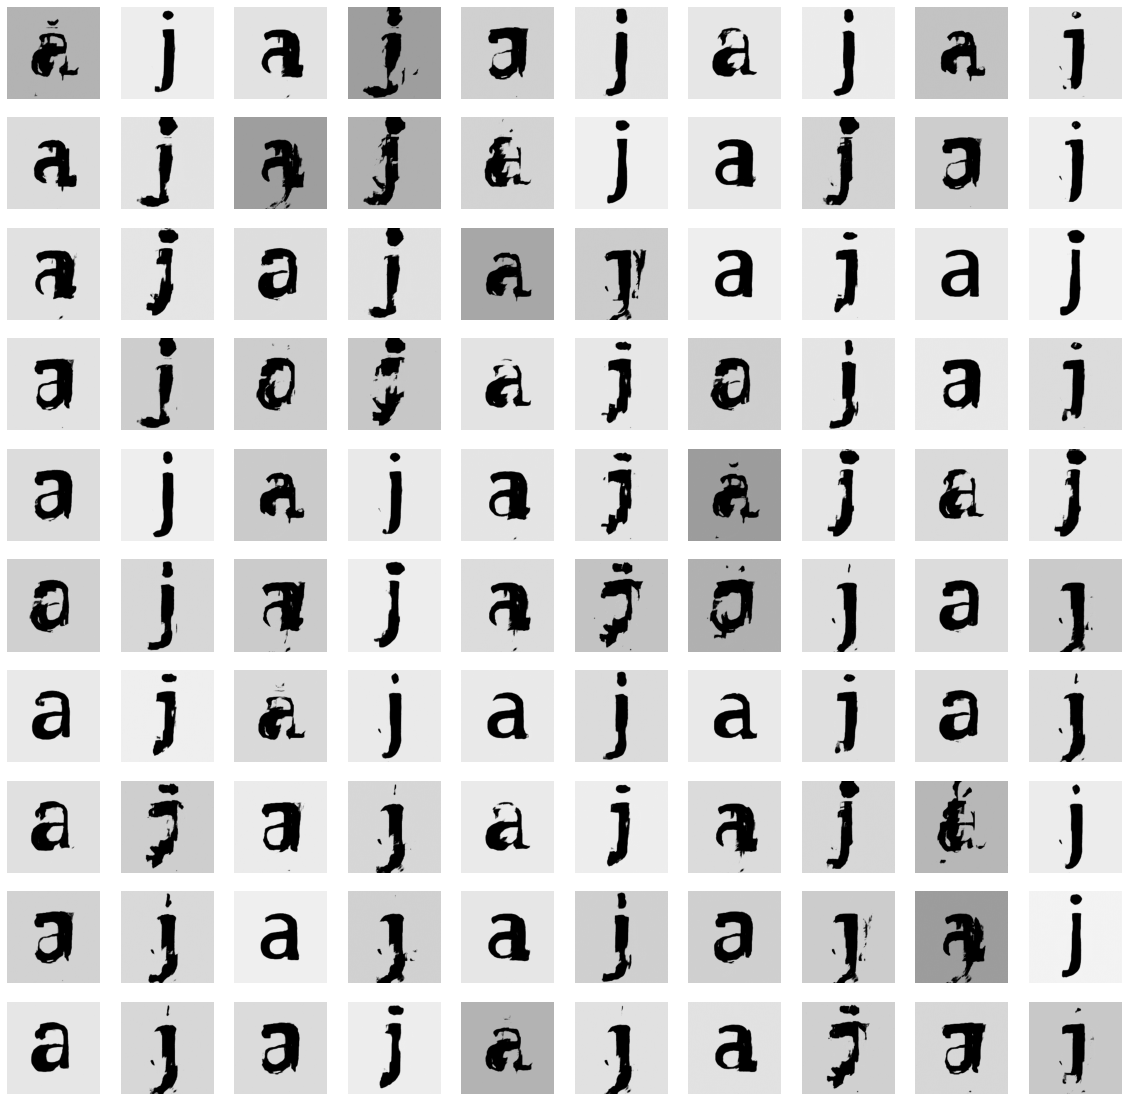

In [221]:
#Load model
model = load_model('conditional_test_aj_chars_large_100xx2_gen.h5')

#Generate points for 100 images
latent_points, labels = generate_conditional_latent_points(2, 100)

#Specify labels, 50 'a' and 'j' pairs
labels = np.asarray([x for _ in range(50) for x in range(2)])

#Generate images using generated points
Xc  = model.predict([latent_points, labels])

#Show generated images in 10x10 grid
show_conditional_plot(Xc, 10)

**Finding:** While this could likely benefit from additional training, this is looking much more diverse. In both the generated 'a' and 'j' characters I can observe variation in the thickness, curvature, and their overall shape and structure.  

With a major change in the range of the generated latent points (+/- 25), the orginal model I was using was likely generating for a very narrow band in the latent space of both the 'a' and the 'j' characters, which explains the original lack of diversity.  

While creating a multiple to modify the latent points works, a better solution would likely be to standardize the latent spaces of each character (between -1 and 1). This solution would allow for scalability for additional classes and account for large variatons in latent space representations between characters.  

===================================================================================================================

## Fit Conditional DCGAN (62 Characters)

This approach is very much the same as above.  
Will adjust the architecture to support all 62 classes and reduce the image size to 56x56 to hlep save on memory and speed training.

### Load Clean Character Data

In [28]:
#Inspect the class order for full 62 character set
folder='classes/'
class_folders = os.listdir(folder)
class_folders.remove('.DS_Store')
class_folders

['Uu',
 'Yy',
 'Pp',
 'Bb',
 'Nn',
 'Gg',
 'Kk',
 'Ii',
 'Ee',
 'Ll',
 'r',
 'u',
 '9',
 '0',
 '7',
 'Rr',
 'i',
 'n',
 'g',
 '6',
 'z',
 '1',
 '8',
 't',
 's',
 'a',
 'f',
 'o',
 'h',
 'Ww',
 'Ss',
 'Vv',
 'Zz',
 'Dd',
 'Hh',
 'Aa',
 'Mm',
 'Oo',
 'Cc',
 'Jj',
 'Ff',
 'm',
 'j',
 'c',
 'Xx',
 'Tt',
 'd',
 'v',
 'q',
 '4',
 'x',
 '3',
 'e',
 'b',
 'k',
 'l',
 '2',
 'y',
 '5',
 'p',
 'Qq',
 'w']

In [29]:
#Use Datagenerator to load in the clean character data
#Reducing image size (56x56px) with larger batch size of 256 to speed training
datagen = ImageDataGenerator(rescale=1/255)
char_gen = datagen.flow_from_directory(folder, target_size=(56, 56), batch_size=256, color_mode='grayscale', shuffle=True, class_mode='categorical', classes=class_folders)

Found 225840 images belonging to 62 classes.


In [30]:
X, y = next(char_gen)

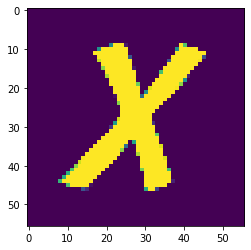

In [31]:
first_char = X[0]
plt.imshow(first_char)
plt.show()

In [32]:
#Verify the classes line up
idx = list(y[0]).index(1)
print(class_folders[idx])

Xx


In [33]:
print(X.shape)
print(y.shape)

(256, 56, 56, 1)
(256, 62)


### Defining Functions for 62 Charachters

Defining functions for the updated models.  
Only updates are to the the generator, descriminator and training loop.  
The rest of the functions are the same as above, or can be modified through the parameters in the training loop.

In [34]:
def define_conditional_discriminator(in_shape=(56, 56, 1), n_classes=62):
    #Create label embedding
    #Use 76 as the embedding output dimensions (worked better than 50)
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 76)(in_label)
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    
    #Concatenate with class label
    in_image = Input(shape=in_shape)
    merge = Concatenate()([in_image, li])
    #Downsample to reduce size
    fe = Conv2D(128, kernel_size=(3, 3), strides=(2,2))(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    #Downsample again
    fe = Conv2D(128, kernel_size=(3, 3), strides=(2,2))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    #Flatten for output layer
    fe = Flatten()(fe)
    fe = Dropout(0.25)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)
    model = Model([in_image, in_label], out_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [35]:
def define_conditional_generator(latent_dim, n_classes=62):
    #Prepare and size input
    #Starting with smaller (14x14px) images
    in_label = Input(shape=(1,))
    li = Embedding(n_classes, 76)(in_label)
    n_nodes = 14*14
    li = Dense(n_nodes)(li)
    li = Reshape((14, 14, 1))(li)
    in_lat = Input(shape=(latent_dim,))
    n_nodes = 128 * 14 * 14
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((14, 14, 128))(gen)
    
    #Concatenate with class label
    merge = Concatenate()([gen, li])
    #Upsample to 28x28
    gen = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2))(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    #Upsample again to 56x56
    gen = Conv2DTranspose(128, kernel_size=(3, 3), strides=(2,2))(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    out_layer = Conv2D(1, kernel_size=(4, 4), activation='tanh')(gen)
    model = Model([in_lat, in_label], out_layer)
    return model

In [37]:
#Training loop
def train_conditional(g_model, d_model, gan_model, char_gen, latent_dim, filename, n_epochs=100, n_batch=256):
    batch_per_epoch = int(225840 / n_batch) #Number of images
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        batches = 0
        #Loop through DataImageGenerator fully for each epoch
        for X, y in char_gen:
            y = np.array([np.array(list(cls).index(1)) for cls in y])
            #Toggle trainability of descriminator
            d_model.trainable = True
            [X_real, labels_real], y_real = generate_conditional_real_samples(X, y, half_batch)
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            [X_fake, labels_fake], y_fake = generate_conditional_fake_samples(g_model, latent_dim, half_batch)
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            [z_input, labels_input] = generate_conditional_latent_points(latent_dim, n_batch, n_classes=62)
            y_gan = np.ones((n_batch, 1))
            d_model.trainable = False
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            print('>%d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, batches+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
            batches += 1
            if batches >= batch_per_epoch:
              #Break manually to avoid infinite loop
              break
    g_model.save('{}.h5'.format(filename))

In [38]:
#Define models for all 62 chars
latent_dim = 100
discriminator = define_conditional_discriminator()
generator = define_conditional_generator(latent_dim)
gan_model = define_conditional_gan(generator, discriminator)

In [ ]:
#Trained on Amazon Sagemager to utilize GPU
#Ran into training difficulties here. Even with just 2 epochs, the train time was 20 hours.
#Have submitted a request to use a paid, higher power GPU but am awaiting account approval from AWS.
train_conditional(generator, discriminator, gan_model, char_gen, latent_dim, 'conditional_test_all_2', n_epochs=2)

**Train Screenshot from AWS Sagemaker**
<img src="images/sagemaker_train.png">

IndexError: index 62 is out of bounds for axis 0 with size 62

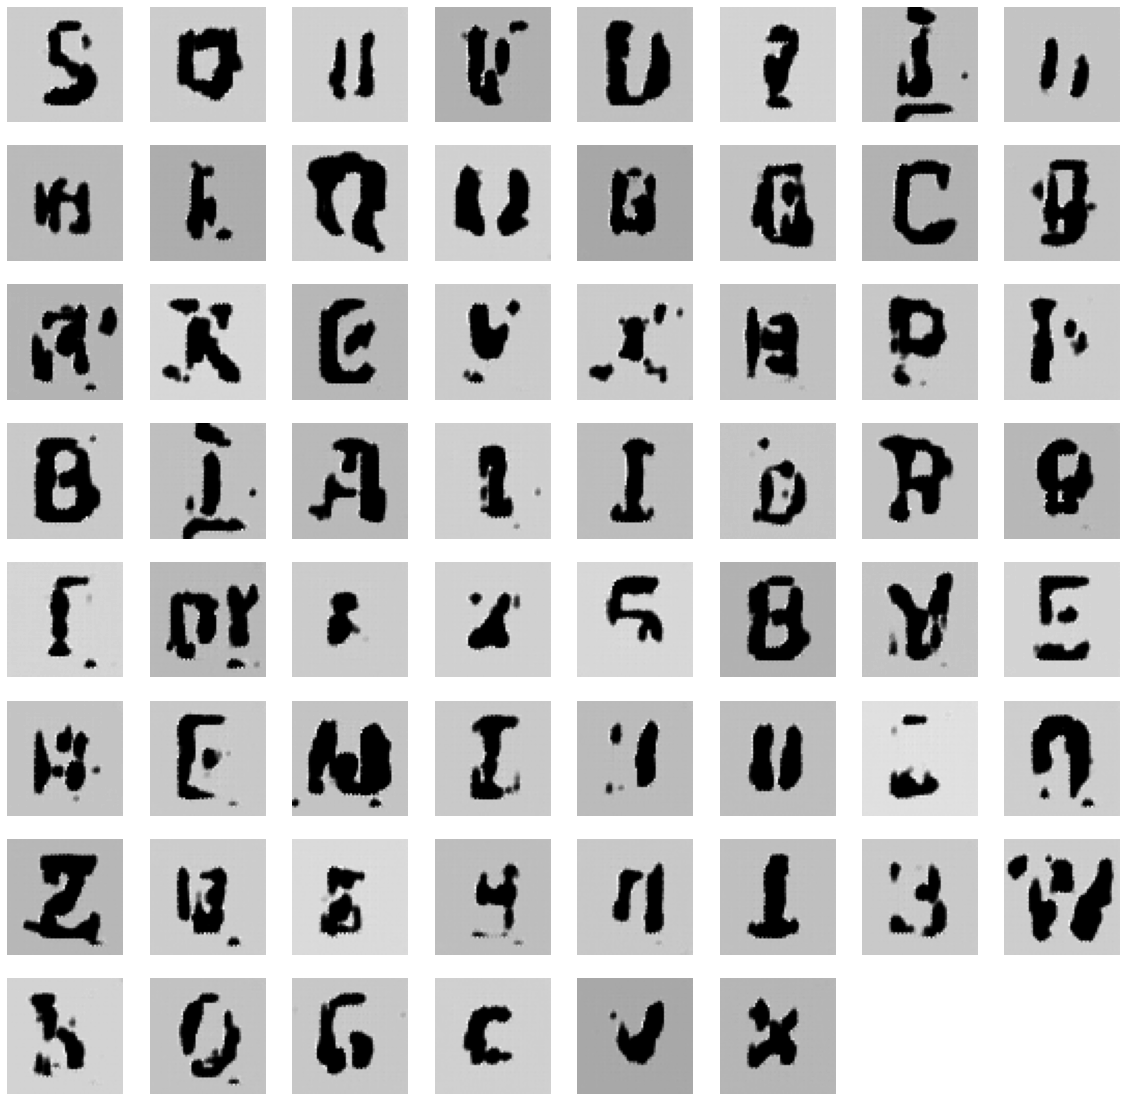

In [40]:
#Load model
model = load_model('conditional_test_all_2.h5')

#Generate points for 64 images
latent_points, labels = generate_conditional_latent_points(100, 62)

#Specify labels, 50 'a' and 'j' pairs
labels = np.asarray([x for _ in range(1) for x in range(62)])

#Generate images using generated points
Xc  = model.predict([latent_points, labels])

#Show generated images in 8x8 grid
#This will show an IndexError as the inputs ar two characters short
show_conditional_plot(Xc, 8)

**Note:** The class order on Amazon Sagemaker was different from my local directory (screenshot below).  
On inspection, the classes do line up with the model generating for each of the 62 classes.  
This result is consistent with how the generated 'a' and 'j' characetrs looked after 2 epochs.  
However, I will need more compute from AWS to run something closer to 50 epochs for the final model.

**Class Order Screenshot from AWS Sagemaker Notebook**
<img src="images/sagemaker_class-order.png">